# LevanteDP Anemia

In [1]:
from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter
import matplotlib.pyplot as plt
import pandas as pd

import importPeritoneal as i
import Anemia as a
import hospital as h

## Load Data

In [2]:
#file_path = ['/home/jovyan/work/Data/LevanteDP/LevanteDPC.xls']
file_path = ['/home/jovyan/work/Data/LevanteDP/LevanteDPC.xls', '/home/jovyan/work/Data/LevanteDP/LevanteDPPeset.xlsx']

# Load data from excel file
dfs_base = i.load_excel_files(file_path)
merged_df = i.merge_dataframes(dfs_base['Analíticas'], dfs_base['Pacientes'], 'REGISTRO')

# Save them as pickle for fast loading in testing
merged_df.to_pickle('merged_df.pkl')
dfs_base['Ingresos'].to_pickle('Ingresos.pkl')

In [3]:
# Load the data
merged_df = pd.read_pickle('merged_df.pkl')
dfs_base['Ingresos'] = pd.read_pickle('Ingresos.pkl')

## Preprocesado de datos

In [4]:
# Basic data variables
baseline_cat_cols = ['SEXO', 'CKD_STAGE', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR']
baseline_num_cols = ['EDAD', 'CKD_CALC', 'GLUCOSA', 'UREA', 'CREATININA', 'URICO', 'SODIO', 'POTASIO', 'CALCIO', 'FOSFORO', 'HIERRO', 'TRANSFERRINA', 'IST', 'FERRITINA', 'COLESTEROL', 'TRIGLICERIDOS', 'HDL', 'LDL', 'LEUCOCITOS', 'NEUTROFILOS', 'LINFOCITOS', 'MONOCITOS', 'EOSINOFILOS', 'BASOFILOS', 'GRANULOCITOS', 'HEMATIES', 'HEMOGLOBINA', 'HEMATOCRITO', 'VCM', 'HCM', 'CHCM', 'PLAQUETAS', 'PLAQUETOCRITO', 'VPM']

basic_cols_lab = ['REGISTRO', 'FECHA', 'HEMOGLOBINA', 'INICIO_DP']
basic_cols_hosp = ['REGISTRO', 'FINGRESO']
basic_cols_per = ['REGISTRO', 'FECHA']

bool_col_list = ['CARDIORENAL', 'PASO_A_HD', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'FRAGNOS', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR', 'OTROSFR', 'CIRUGIA']
covariate_list = ['HEMOGLOBINA', 'IST', 'HIERRO']
exclude_list = ['CARDIO']


# Clean NaNs for interesting columns
lab_df = i.clean_df(merged_df, basic_cols_lab, verbose=True)
lab_df = i.clean_df(lab_df, covariate_list, verbose=True)
hosp_df = i.clean_df(dfs_base['Ingresos'], basic_cols_hosp, verbose=True)
per_df = i.clean_df(dfs_base['Peritonitis'], basic_cols_per, verbose=True)

# Select years
lab_df, hosp_df, per_df = i.filter_by_year([lab_df, hosp_df, per_df], ['FECHA', 'FINGRESO', 'FECHA'], 2009, 2024)


# Add anemia column based on 'HEMOGLOBINA' and 'SEXO' specified in KDIGO guidelines
a.add_anemia_column(lab_df)
i.add_age_column(lab_df)
i.add_ckd_column(lab_df)

# Fill empty values for bool_cols
lab_df = i.bool_col_convert(lab_df, bool_col_list)

# Exclude patients with exclude_list
#lab_df = lab_df[lab_df['ICEDAD'] <= 11]
lab_df = i.exclude_patients(lab_df, exclude_list, verbose=True)

# Add days since the start of pd for every column in both dataframes
lab_df = h.add_days_since_start(lab_df, lab_df, 'FECHA')
hosp_df = h.add_days_since_start(lab_df, hosp_df, 'FINGRESO')
per_df = h.add_days_since_start(lab_df, per_df, 'FECHA')


# Now keep only the first year after the patients started PD
lab_df = h.filter_df(lab_df, 'days_since_start', 0, (365), verbose=True)
hosp_df = h.filter_df(hosp_df, 'days_since_start', 0, (365), verbose=True)
per_df = h.filter_df(per_df, 'days_since_start', 0, (365), verbose=True)

# Create the cox_df with all necessary data
cox_df = h.prepare_cox_df(lab_df, hosp_df, covariate_list)
cox_time_varying_df = h.cox_time_varying_prep(lab_df, hosp_df, covariate_list, 365)

cox_df_per = h.prepare_cox_df(lab_df, per_df, covariate_list)

The dataframe had 4747 rows (Unique patients: 470), after the clean up of missing values, it has 4617 rows (Unique patients: 467)
The dataframe had 4617 rows (Unique patients: 467), after the clean up of missing values, it has 4503 rows (Unique patients: 466)
The dataframe had 1028 rows (Unique patients: 472), after the clean up of missing values, it has 561 rows (Unique patients: 271)
The dataframe had 992 rows (Unique patients: 439), after the clean up of missing values, it has 983 rows (Unique patients: 434)
Rows before excluding patients: 4503
Rows after excluding patients: 2477
Percentage of deleted rows: 44.992227403952924%
Rows before filter: 2477 (Unique patients: 274)
Rows after filter: 1158 (Unique patients: 269)
Rows before filter: 185 (Unique patients: 99)
Rows after filter: 68 (Unique patients: 53)
Rows before filter: 202 (Unique patients: 105)
Rows after filter: 91 (Unique patients: 60)


## 6.1 Cox hemoglobina - hospitalización

<lifelines.CoxPHFitter: fitted with 269 total observations, 217 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 269
number of events observed = 52
   partial log-likelihood = -278.23
         time fit was run = 2024-05-18 21:27:51 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.27      0.76      0.12           -0.52           -0.03                0.60                0.97
IST          0.05      1.05      0.02            0.00            0.10                1.00                1.10
HIERRO      -0.03      0.97      0.01           -0.06           -0.01                0.95                0.99

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -2.19 0.03      5.14
IST            0.00  2.05 0.04      4.62
HIERRO         0.00 -2.50 0.01      6.33
---
Concordance = 0.64
Partial AIC = 562.46
log-likelihood ratio test = 14.83 on 3 df
-log2(p) of ll-ratio test = 8.99

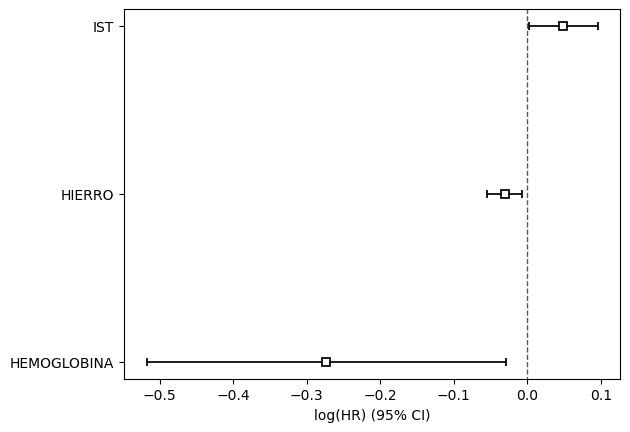

In [5]:
# Initialize the CoxPHFitter

cph = CoxPHFitter()

# Fit the data to the model
cph.fit(cox_df, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph.print_summary()

# Plot the coefficients of the model
cph.plot()
plt.show()

## 6.3 Cox hemoglobina - peritonitis

<lifelines.CoxPHFitter: fitted with 269 total observations, 209 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 269
number of events observed = 60
   partial log-likelihood = -325.06
         time fit was run = 2024-05-18 21:27:51 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA  0.01      1.01      0.11           -0.20            0.22                0.82                1.25
IST          0.05      1.05      0.02            0.01            0.09                1.01                1.10
HIERRO      -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00  0.08 0.93      0.10
IST            0.00  2.58 0.01      6.65
HIERRO         0.00 -2.55 0.01      6.52
---
Concordance = 0.58
Partial AIC = 656.11
log-likelihood ratio test = 7.00 on 3 df
-log2(p) of ll-ratio test = 3.80

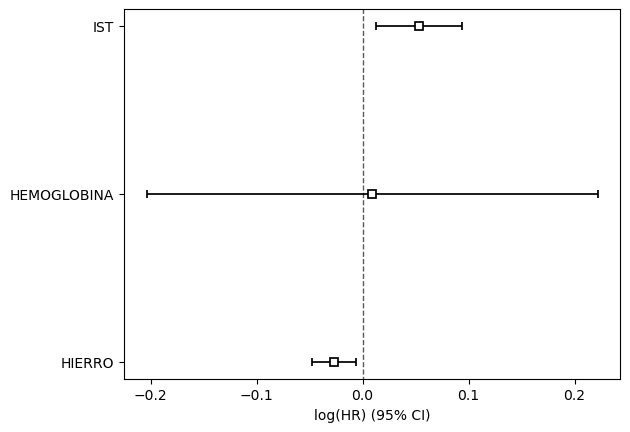

In [6]:
# Initialize the CoxPHFitter

cph = CoxPHFitter()

# Fit the data to the model
cph.fit(cox_df_per, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph.print_summary()

# Plot the coefficients of the model
cph.plot()
plt.show()

## Prevalencia de anemia en pacientes con ERC en DP

The dataframe had 4747 rows (Unique patients: 470), after the clean up of missing values, it has 4485 rows (Unique patients: 466)
Yearly Anemia Prevalence:
2010: 75.0%
2011: 85.71%
2012: 85.11%
2013: 92.31%
2014: 91.67%
2015: 91.43%
2016: 91.11%
2017: 89.42%
2018: 86.84%
2019: 85.27%
2020: 85.48%
2021: 76.92%
2022: 79.57%
2023: 76.62%


/home/jovyan/work/Medicina/LevanteDPAnemia/Anemia.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['ANEMIA'] = input_df.apply(check_anemia, axis=1)


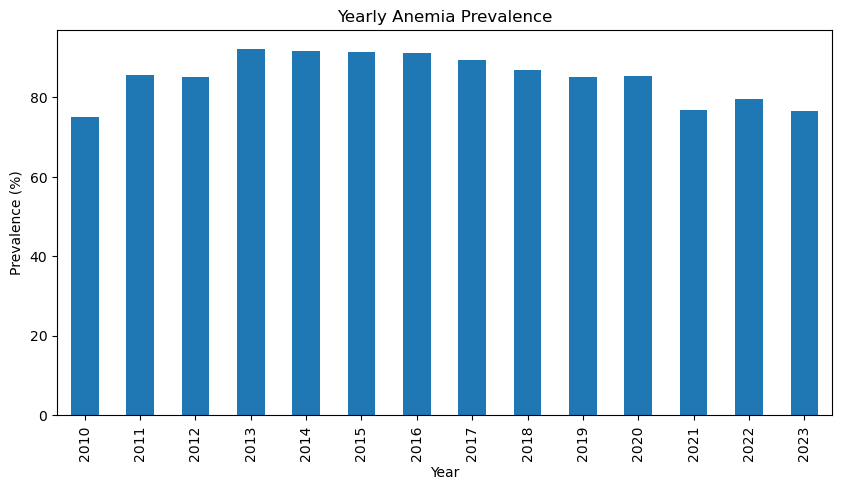

In [7]:
# Reload the full dataframe without filtering

anemia_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'REGISTRO', 'FECHA']
merged_df = pd.read_pickle('merged_df.pkl')
anemia_df = i.clean_df(merged_df, anemia_cols, verbose=True)
a.add_anemia_column(anemia_df)
anemia_df = i.filter_by_year([anemia_df], ['FECHA'], 2009, 2023)[0]
anemia_prevalence = a.anemia_prevalence(anemia_df, print_results=True, print_graph=True, tendency=True)

## Tendencias marcadores de anemia

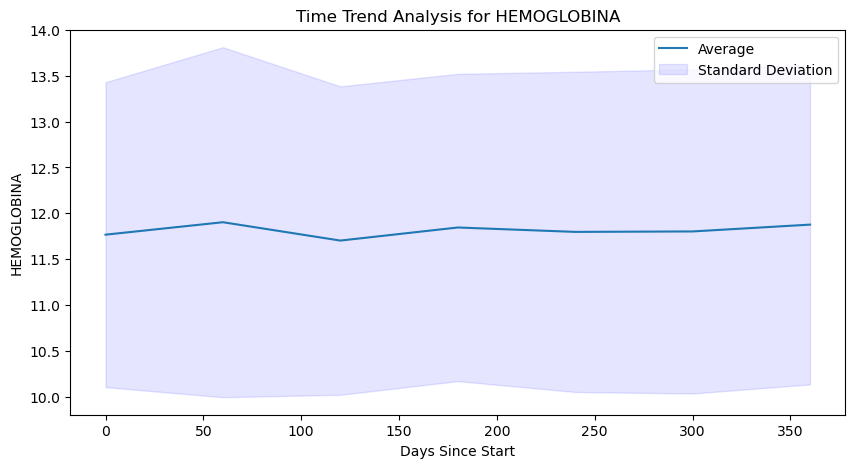

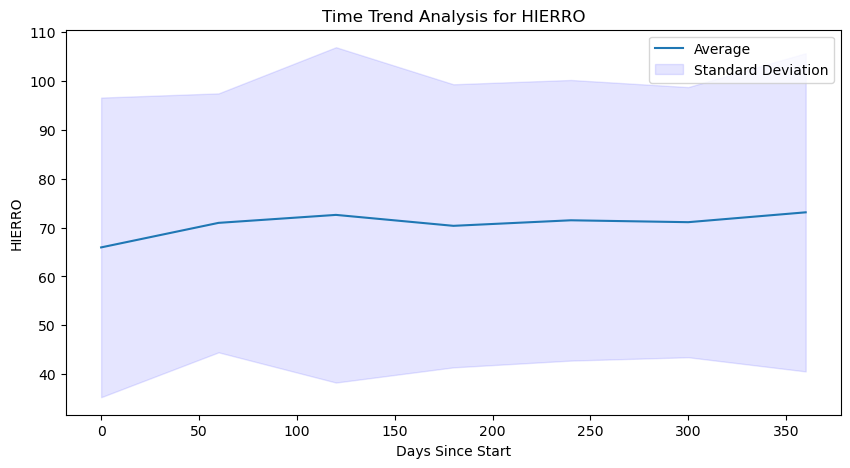

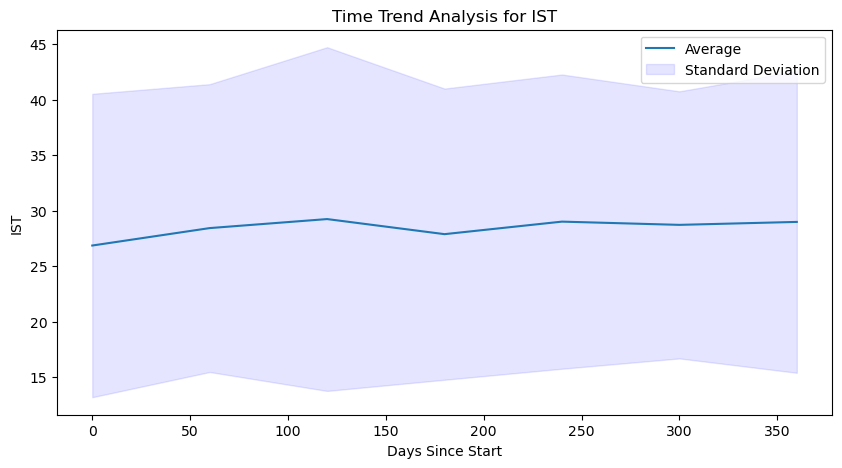

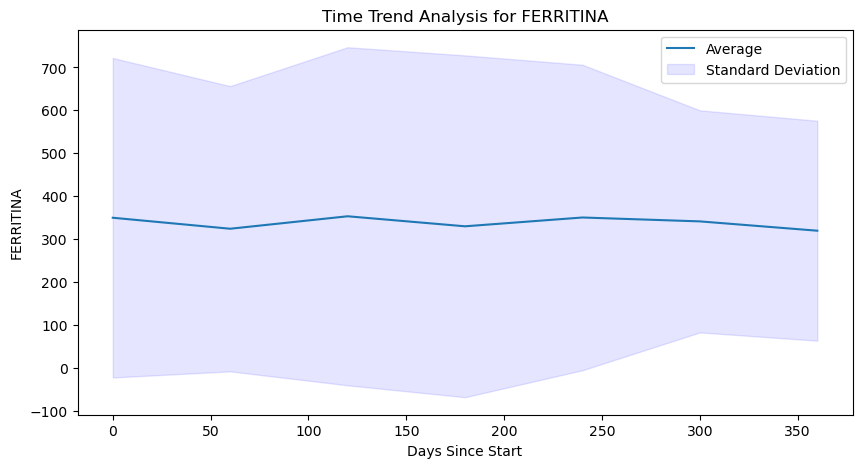

In [8]:
time_trend_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA']
time_trend_df = a.time_trend_analysis(anemia_df, 1, time_trend_cols, 365, plot_results=True)

In [9]:
p_values_test = a.t_test_first_last(time_trend_df, print_results=True)

Column HEMOGLOBINA_avg p-value: nan
Column HIERRO_avg p-value: nan
Column IST_avg p-value: nan
Column FERRITINA_avg p-value: nan


/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [10]:
a.stationary_test(time_trend_df, col_str='_avg')


Testing for stationarity in column: HEMOGLOBINA_avg
ADF Statistic: -5.153881
p-value: 0.000011
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
The data in HEMOGLOBINA_avg is stationary.

Testing for stationarity in column: HIERRO_avg
ADF Statistic: -4.224391
p-value: 0.000599
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
The data in HIERRO_avg is stationary.

Testing for stationarity in column: IST_avg
ADF Statistic: -3.876868
p-value: 0.002212
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
The data in IST_avg is stationary.

Testing for stationarity in column: FERRITINA_avg
ADF Statistic: -2.757278
p-value: 0.064640
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
The data in FERRITINA_avg is not stationary and may need differencing.



In [11]:
print(time_trend_df)

   HEMOGLOBINA_avg  HEMOGLOBINA_std  HIERRO_avg  HIERRO_std    IST_avg  \
0        11.766274         1.662767   65.955189   30.687248  26.864387   
1        11.902111         1.908667   70.981530   26.520975  28.436412   
2        11.701983         1.682217   72.614731   34.343420  29.249008   
3        11.844625         1.675895   70.374593   28.993797  27.889577   
4        11.796679         1.746114   71.509225   28.740971  29.019188   
5        11.801633         1.767836   71.122449   27.667843  28.726939   
6        11.875909         1.742751   73.140909   32.588946  28.993182   

     IST_std  FERRITINA_avg  FERRITINA_std  
0  13.673402     349.858491     372.131225  
1  12.973391     324.253298     332.298281  
2  15.490505     353.288952     393.797849  
3  13.124368     329.921824     398.151711  
4  13.261152     350.439114     355.838117  
5  12.038242     341.379592     258.694133  
6  13.598956     319.668182     256.186618  


## Baseline

In [12]:
baseline = i.calculate_baseline(lab_df, baseline_cat_cols, baseline_num_cols)
i.print_baseline(baseline)

SEXO:
    counts: SEXO
1. Hombre    185
2. Mujer      84
Name: count, dtype: int64
    percentages: SEXO
1. Hombre    68.773234
2. Mujer     31.226766
Name: count, dtype: float64

CKD_STAGE:
    counts: CKD_STAGE
Stage 5     250
Stage 4      16
Stage 3B      3
Name: count, dtype: int64
    percentages: CKD_STAGE
Stage 5     92.936803
Stage 4      5.947955
Stage 3B     1.115242
Name: count, dtype: float64

ARRITMIA:
    counts: ARRITMIA
False            247
True              18
Missing_value      4
Name: count, dtype: int64
    percentages: ARRITMIA
False            91.821561
True              6.691450
Missing_value     1.486989
Name: count, dtype: float64

ITU:
    counts: ITU
False            144
Missing_value    120
True               5
Name: count, dtype: int64
    percentages: ITU
False            53.531599
Missing_value    44.609665
True              1.858736
Name: count, dtype: float64

TBC:
    counts: TBC
False            149
Missing_value    120
Name: count, dtype: int64
    p

In [13]:
'''
Introducción anemia ferropénica (unas 10-20 paginas) en CKD
    Enf renal crónica general -> complicaciones 
    Anemia: importancia, prevalencia, impacto pronóstico...

Hipotesis de trabajo
    Anemia tiene inpacto pronóstico en paciente peritoneal con hospitalizaciones
Definir bien objetivos
    Claros y definidos
    Prevalencia, incidencia, variabilidad y su impacto en hospitalización
    Impacto pronóstico de la anemia en hospitalización y factores de riesgo 
Material y métodos (mitar el TFG dislipemia)
    Registro Levante
Resultados
    Seguir el orden de los objetivos
        Prevalencia
        Incidencia
        Impacto...
Discusión
    Primer párrafo: hallazgo del estudio
    Segundo párrafo: incidencia con otros datos y artículos
    Limitaciones
    Conclusiones: respuesta a objetivos




Contemplar meter variabilidad de Hb y modelos predictivos. Factores predictores de la Hb.


'''


'\nIntroducción anemia ferropénica (unas 10-20 paginas) en CKD\n    Enf renal crónica general -> complicaciones \n    Anemia: importancia, prevalencia, impacto pronóstico...\n\nHipotesis de trabajo\n    Anemia tiene inpacto pronóstico en paciente peritoneal con hospitalizaciones\nDefinir bien objetivos\n    Claros y definidos\n    Prevalencia, incidencia, variabilidad y su impacto en hospitalización\n    Impacto pronóstico de la anemia en hospitalización y factores de riesgo \nMaterial y métodos (mitar el TFG dislipemia)\n    Registro Levante\nResultados\n    Seguir el orden de los objetivos\n        Prevalencia\n        Incidencia\n        Impacto...\nDiscusión\n    Primer párrafo: hallazgo del estudio\n    Segundo párrafo: incidencia con otros datos y artículos\n    Limitaciones\n    Conclusiones: respuesta a objetivos\n\n\n\n\nContemplar meter variabilidad de Hb y modelos predictivos. Factores predictores de la Hb.\n\n\n'